# Week 4 Mini - Project: BBC NEWS CLASSIFICATION

## Part 1: Unsupervised Learning: Matrix Factorization Method

### Introduction

The dataset is part of the Kaggle Competition: BBC News Classification. It contains 2225 articles from BBC and each article is labeled under a specific category. There are five categories: business, entertainment, tech, sport and politics. The objective of this mini-project is to apply matrix factorization techniques on the training data and accurately predict the categories of the unseen test data.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import math
import re

# Machine learning packages
import nltk 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [2]:
bbc_train = pd.read_csv("C:/Users/venuk/Desktop/dtsa-5510/Mini/BBC News Train.csv")
bbc_test = pd.read_csv("C:/Users/venuk/Desktop/dtsa-5510/Mini/BBC News Test.csv")

In [3]:
bbc_train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [4]:
bbc_test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


### Data Cleaning and Exploratory Data Analysis

First step is to clean the data of null and/or duplicated values. Having null or duplicate values will give an inaccurate feedback in the final result and the algorithm or model is unreliable.

In [5]:
bbc_train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [6]:
bbc_train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

There seems to be 50 duplicated texts which we will remove from the dataset. This will help have a more accurate outcome on our model.

In [7]:
bbc_train = bbc_train.drop_duplicates(subset = ['Text'])

Now the data has no duplicated or null values. Now applying EDA techniques to help understand the training data better and then extract word features. To avoid bias in results, I won't visualize or explore the test set.

In [8]:
bbc_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1440 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1440 non-null   int64 
 1   Text       1440 non-null   object
 2   Category   1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 45.0+ KB


In [9]:
bbc_train.describe(include = 'object')

,Text,Category
count,1440,1440
unique,1440,5
top,worldcom ex-boss launches defence lawyers defe...,sport
freq,1,342


The 'Text' and 'Category' are object-type attributes while the ArticleId is integer-type. There are 5 unique categories and 1440 unique text. Below we will see the how many articles are in each category.

In [10]:
bbc_train['Category'].value_counts()

sport            342
business         335
politics         266
entertainment    263
tech             234
Name: Category, dtype: int64

Text(0.5, 1.0, 'The Distribution of Articles in Each Category')

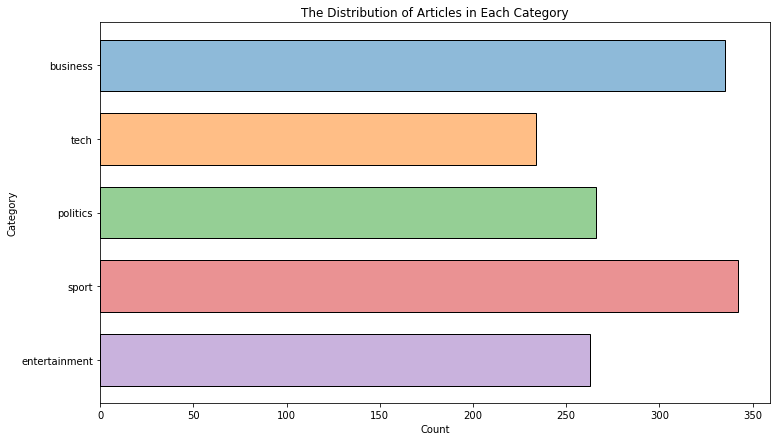

In [11]:
# Visualizing the number of articles per cateogry
f, ax = plt.subplots(figsize = (12, 7))
sns.histplot(data = bbc_train, y = "Category", hue = "Category",  shrink = .7, legend = False)
plt.title("The Distribution of Articles in Each Category")

There are more articles from business and sport than the other categories.

Now we will look at the 'Text' category to see how the data is saved. We will visualize the length of text in each article and in each category.

In [12]:
bbc_train["Text"][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [13]:
bbc_train["Text"][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

Text(0.5, 1.0, 'The Distribution of Characters per Article')

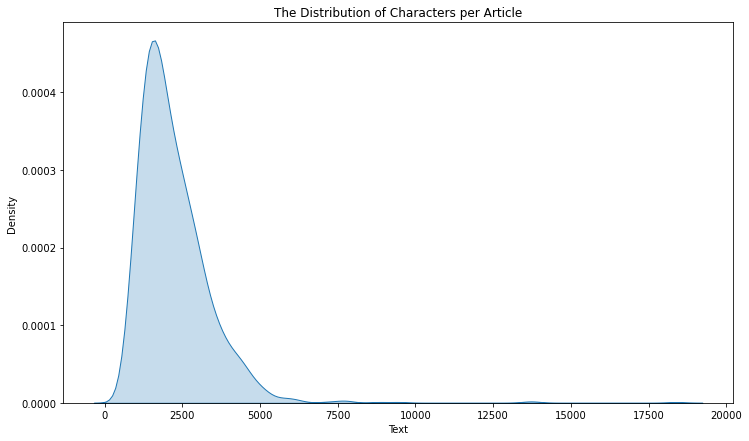

In [14]:
# Visualizing number of characters in each article
f, ax = plt.subplots(figsize = (12, 7))
sns.kdeplot(data = bbc_train, x = bbc_train['Text'].str.len(), fill = True)
plt.title("The Distribution of Characters per Article")

Text(0.5, 1.0, 'The Distribution of Characters per Article in Each Category')

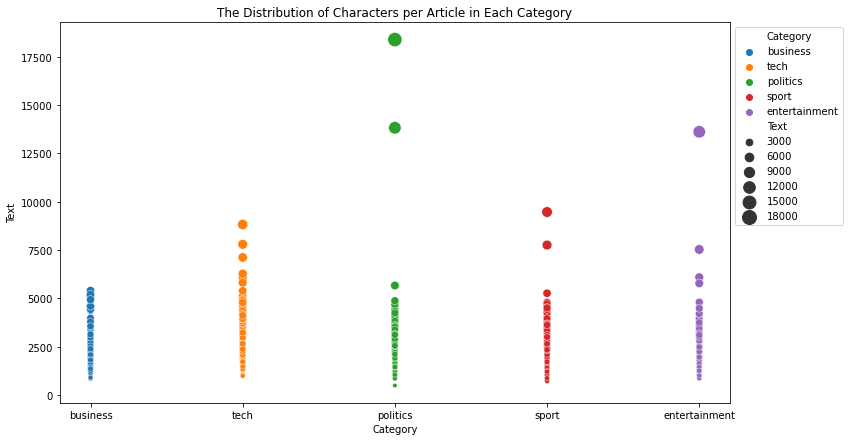

In [15]:
# Visualizing number of characters in each Category
f, ax = plt.subplots(figsize = (12, 7))
sns.scatterplot(data = bbc_train, x = "Category", y = bbc_train['Text'].str.len(), 
             hue = "Category", size=bbc_train['Text'].str.len(), sizes = (20, 200))
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("The Distribution of Characters per Article in Each Category")

Most articles have a text length less than 3000 characters while a very small amount are more than 5000. Business articles have text lengths that are relatively smaller than the rest while politics has the highest text length for an article.

Text(0.5, 1.0, 'The Distribution of Number of Words per Article in Each Category')

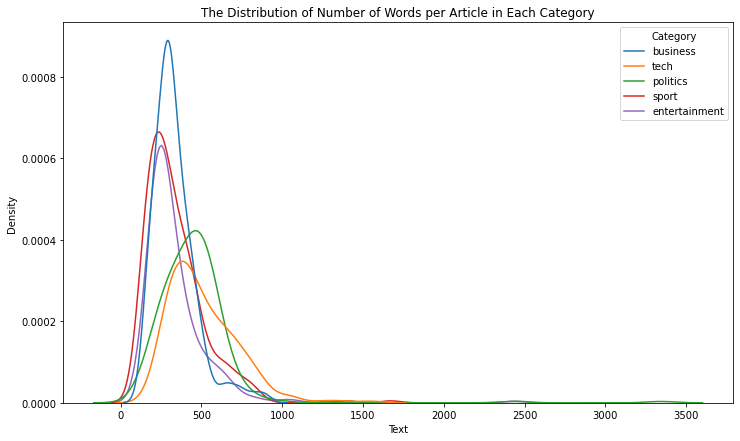

In [16]:
# Visualizing number of words in each Category
bbc_train['Text'].str.split().map(lambda x: len(x))

f, ax = plt.subplots(figsize = (12, 7))
sns.kdeplot(data = bbc_train, x = bbc_train['Text'].str.split().map(lambda x: len(x)), 
             hue = "Category")
plt.title("The Distribution of Number of Words per Article in Each Category")

Average number of words per article seems to be under 500. Business articles have the highest number of articles with less than 500 words. Politics articles have highest number of words (>3500 words).

#### Text Processing

Now we will preprocess the text so that we can use it in further analysis. Although the above 2 texts seem to be in lowercase, we will apply the step again to make sure the rest of the texts are also lowercase. The text should be "readable" for the computer programs to use. So we should remove punctuations, special characters and stopwords such as (of, in, is, an, the, to, etc). I will also remove numeric characters as well to make the text easier to analyze.

In [17]:
#Lowercase all text
bbc_train["Text"] = bbc_train["Text"].str.lower()

#Remove numeric and special characters, including punctuation
bbc_train["Text"] = bbc_train["Text"].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
bbc_train["Text"] = bbc_train["Text"].apply(lambda row: re.sub(r'[0-9]', '', row))

In [18]:
#Remove stopwords
stopwords = nltk.corpus.stopwords.words('english')

bbc_train["Text"] = bbc_train["Text"].apply(lambda words: ' '.join(word for word in words.split() if word not in stopwords))

In [19]:
# Checking if punctuation, other unnecessary and stopwords have been removed.
bbc_train["Text"][0]

'worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant warnings led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness former worldcom fin

In the next step, I will tokenize and lemmatize the text. 

Tokenization is a technique to break down sentences into a stream of words called tokens. This can be used for further analysis or in other methods for natural language processing.

Lemmatization is text preprocessing technique similar to stemming since they can be used to convert words into their root form. Lemmatization is more advanced since it actually transforms the word to its actual root by using a dictionary. Because it tries to be more accurate, it requires more processing power and time to generate an output. However since I'm trying to classify news articles, it would be better to have more accurate conversions of the word to its root.  

In [20]:
# Function for lemmatizing text
# Refer to #1, #2 in References
wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatizer(text):
    tokens = nltk.word_tokenize(text)
    lem_text = ' '.join([wordnet_lemmatizer.lemmatize(w) for w in tokens])
    return lem_text

In [21]:
bbc_train['Text'] = bbc_train['Text'].apply(lemmatizer)

In [22]:
bbc_train['Text'][0]

'worldcom exboss launch defence lawyer defending former worldcom chief bernie ebbers battery fraud charge called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted director irregular accounting practice u telecom giant warning led collapse firm following discovery bn bn accounting fraud mr ebbers pleaded guilty charge fraud conspiracy prosecution lawyer argued mr ebbers orchestrated series accounting trick worldcom ordering employee hide expense inflate revenue meet wall street earnings estimate m cooper run consulting business told jury new york wednesday external auditor arthur andersen approved worldcom accounting early said andersen given green light procedure practice used worldcom mr ebber lawyer said unaware fraud arguing auditor alert problem m cooper also said shareholder meeting mr ebbers often passed technical question company finance chief giving brief answer prosecution star witness former worldcom financial chief scott sullivan 

### Feature Extraction: TF-IDF Vectorizer

#### Brief Summary about TF-IDF 
Term Frequency - Inverse Document Frequency, or TF-IDF, is a measure used to evaluate how meaningful a word is to a document among a collection of documents. It vectorizes a word by multiplying the word's Term Frequency (TF) with the Inverse Document Frequency (IDF).

**TF** = No. of times a certain word appears in document. 

**IDF** = Weight of the term or the measure of how common or uncommon the word is across the entire set of documents. In sklearn, IDF is calculated by:

$$IDF(t) = \log \frac{(1+n)}{1 + DF(t)} + 1$$
where, 
- ***t*** = term that is being measured 
- ***n*** = number of total documents in the corpus 
- ***DF(t)*** = Number of documents in which term, t appears 
      
The TF-IDF score is between 0 and 1. The more relevant the term, the higher TF-IDF value (approaching 1).

I will be using sklearn's TF-IDF Vectorizer for processing raw text to feature vectors. By doing this, it will distinguish how relevant a term is to a document proportional to it's importance across all documents in the corpus. This can help distinguish the top words in each category which can help with further classification.

In [23]:
#Initialise the vectorizer, using default settings
tfidf_vec = TfidfVectorizer()

#convert text to matrix form
features = tfidf_vec.fit_transform(bbc_train["Text"]).toarray()     

#Get feature names
features_names = tfidf_vec.get_feature_names_out()

features.shape

(1440, 22674)

In [24]:
#set labels to target column in bbc_train
labels = bbc_train["Category"] 

labels.shape

(1440,)

### NMF Model Building and Training

For this project, I chose Non-Negative Matrix Factorization (NMF) method as my unsupervised learning approach. 

The main objective of unsupervised learning algorithms is to find hidden patterns or trends in unlabeled data. So the test dataset can be included with the training dataset for analysis. 

However for training the NMF model, I only used the training dataset to analyze the model performance and how well it could label the articles.

In [25]:
#Method from Week 2 Clustering Assignment: Permutate labels and find the best permutation with the highest accuracy
def label_permute_compare(ytdf,yp,n=5):
    vals = list(bbc_train["Category"].unique())
    nums = [0, 1, 2, 3, 4]
    labels = dict(zip(vals, nums))
    perms = list(itertools.permutations(labels))
    acc = []
    prec = []
    recall = []
    cm = []
    for i in range(len(perms)):
        ypred = np.choose(yp, perms[i])
        
        #calculate accuracy for each permutation
        acc.append(metrics.accuracy_score(ytdf, ypred))
       
        #calculate precision for each permutation
        prec.append(metrics.precision_score(ytdf, ypred, average = None))
        
        #calculate recall for each permutation
        recall.append(metrics.recall_score(ytdf, ypred, average = None))
        
        #confusion matrix
        cm.append(metrics.confusion_matrix(ytdf, ypred))
    #get the index of highest accuracy    
    idx = np.argmax(acc)   
    pm = dict(zip(nums, perms[idx]))
    scores = {'Accuracy' : round(acc[idx], 4),
              'Precision' : round(prec[idx].mean(), 4),
              'Recall' : round(recall[idx].mean(), 4)}
    print('Best Permutation of Labels')
    print(pm)
    print('Confusion Matrix:')
    print(cm[idx])
    #Get the labels of best permutation and its accuracy
    return scores

In [26]:
#helper function for NMF model
def nmf_model(n, mtype, stype, alpha_w):
    return NMF(n_components = n, beta_loss = mtype, solver = stype, 
               alpha_W = alpha_w, init = 'nndsvda')

In [27]:
#Initialize model
model = nmf_model(5, 'frobenius', 'cd', 0.00005)

#Get transformed data matrix for X_train
nmf_features = model.fit_transform(features)

# Get the predicted label for each document by using argmax to get the highest predicted probabilities of each row
# Refer to #12 in References
yp_train = np.argmax(nmf_features, axis=1)

#Best permuted label order and evaluation metrics
score_train = label_permute_compare(labels, yp_train)
print("Evaluation of Predicted Train Labels:", score_train)

Best Permutation of Labels
{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
Confusion Matrix:
[[309   1  12   1  12]
 [  5 195   8  17  38]
 [ 14   0 242   6   4]
 [  0   2   0 340   0]
 [  2   3   3   9 217]]
Evaluation of Predicted Train Labels: {'Accuracy': 0.9049, 'Precision': 0.9064, 'Recall': 0.899}


In [28]:
# Function to display top words for each label
def display_top_words(nmfmodel, f_names, num_top_words):
    for ix, topic in enumerate(model.components_):
        print("Label ", ix)
        print(", ".join([f_names[i] \
             for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [29]:
display_top_words(model, features_names, 10)

Label  0
game, england, win, player, wale, ireland, cup, match, said, team
Label  1
mr, labour, election, blair, party, tory, brown, tax, said, minister
Label  2
mobile, phone, people, music, technology, said, service, user, broadband, net
Label  3
film, award, best, actor, oscar, actress, star, nomination, director, festival
Label  4
bn, growth, economy, rate, said, bank, year, market, economic, sale


### Hyperparameter Tuning

For the initial model, I chose the hyperparameters(n_components = 5, beta_loss = frobenius, solver = cd, alpha_W = 0.0). The model had a good accuracy on the training set, but had a poor accuracy on the test set when submitted to Kaggle. 

Decreasing the n_components reduced the accuracy of the model. Increasing the alpha_W to 0.00005 decreased the accuracy of the models using Frobenius beta_loss on both the training set and test. For the model using Kullback-Leibler, the accuracy of the test set remained unaffected, but the accuracy if the training set slightly decreased when increasing alpha_W.

Experimenting with the hyperparameters of beta_loss, solver and alpha_W, the model with hyperparameters(n_components = 5, beta_loss = kullback-leibler, solver = mu, alpha_W = 0.00005) had the highest accuracy for the training model.

In [30]:
#Initialize model
model1 = nmf_model(5, 'frobenius', 'mu', 0.00005)

#Get transformed data matrix for X_train
nmf_features1 = model1.fit_transform(features)

#Get the predicted label for each document
yp_train1 = np.argmax(nmf_features1, axis=1)

#Best permuted label order and evaluation metrics
score1_train = label_permute_compare(labels, yp_train1)
print("Evaluation of Predicted Train Labels:", score1_train)

Best Permutation of Labels
{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
Confusion Matrix:
[[307   1  12   3  12]
 [  5 199   7  22  30]
 [ 11   0 242   9   4]
 [  0   2   0 340   0]
 [  1   3   3  14 213]]
Evaluation of Predicted Train Labels: {'Accuracy': 0.9035, 'Precision': 0.9067, 'Recall': 0.8975}


In [31]:
display_top_words(model, features_names, 10)

Label  0
game, england, win, player, wale, ireland, cup, match, said, team
Label  1
mr, labour, election, blair, party, tory, brown, tax, said, minister
Label  2
mobile, phone, people, music, technology, said, service, user, broadband, net
Label  3
film, award, best, actor, oscar, actress, star, nomination, director, festival
Label  4
bn, growth, economy, rate, said, bank, year, market, economic, sale


In [32]:
#Initialize model
model2 = nmf_model(5, 'kullback-leibler', 'mu', 0.00005)

#Get transformed data matrix for X_train
nmf_features2 = model2.fit_transform(features)

#Get the predicted label for each document
yp_train2 = np.argmax(nmf_features2, axis=1)

#Best permuted label order and evaluation metrics
score2_train = label_permute_compare(labels, yp_train2)
print("Evaluation of Predicted Train Labels:", score2_train)

Best Permutation of Labels
{0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}
Confusion Matrix:
[[267   3  15   2  48]
 [  2 242   1  14   4]
 [  3   2 252   8   1]
 [  3   2   0 337   0]
 [  0   4   2   9 219]]
Evaluation of Predicted Train Labels: {'Accuracy': 0.9146, 'Precision': 0.9153, 'Recall': 0.9172}


In [33]:
display_top_words(model, features_names, 10)

Label  0
game, england, win, player, wale, ireland, cup, match, said, team
Label  1
mr, labour, election, blair, party, tory, brown, tax, said, minister
Label  2
mobile, phone, people, music, technology, said, service, user, broadband, net
Label  3
film, award, best, actor, oscar, actress, star, nomination, director, festival
Label  4
bn, growth, economy, rate, said, bank, year, market, economic, sale


<p style="text-align: center; text-style: bold"><strong>Model Performance on Predicting Labels for X_Test Data</strong></p>

| NMF Model Parameters                   | Accuracy | Precision | Recall |
|----------------------------------------|----------|-----------|--------|
| NMF(5, frobenius, cd, 0.00005)         | 0.9049   | 0.9064    | 0.899  |
| NMF(5, frobenius, mu, 0.00005)         | 0.9035   | 0.9067    | 0.8975 |
| NMF(5, kullback-leibler, mu, 0.00005)  | 0.9146   | 0.9153    | 0.9172 |

#### Can we improve model?

By changing the parameters of the TfidfVectorizer to ngram_range(1, 2), max_df = 0.95 and min_df = 2, the model performance improved to an accuracy of 0.95. Reducing the amount of training data used did not improve the accuracy. 

*Note: Ngram is a string of words. The ngram_range(1, 2) means both unigrams(a string of 1 word) and bigrams(a string of 2 words) will be extracted.*

In [34]:
#Initialise the vectorizer
tfidf = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.95, min_df = 2)

#convert text to matrix form
features_new = tfidf.fit_transform(bbc_train["Text"]).toarray() 

features_new_names = tfidf.get_feature_names_out()

In [35]:
#Using the model2 since it had the highest accuracy
#Get transformed data matrix for features_new
nmf_features_new = model2.fit_transform(features_new)

#Get the predicted label for each document
yp_new = np.argmax(nmf_features_new, axis=1)

#Best permuted label order and evaluation metrics
score_new = label_permute_compare(labels, yp_new)
print("Evaluation of Predicted Test Labels:", score_new)

Best Permutation of Labels
{0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}
Confusion Matrix:
[[310   1  13   6   5]
 [  1 245   2   5  10]
 [  3   1 252   7   3]
 [  0   1   0 341   0]
 [  8   2   1   3 220]]
Evaluation of Predicted Test Labels: {'Accuracy': 0.95, 'Precision': 0.9499, 'Recall': 0.9483}


In [36]:
display_top_words(model2, features_new_names, 10)

Label  0
could got, climbed, make top, gas deal, lucrative, dokic, brothel, exchange reserve, hope reach, know right
Label  1
fellow uk, editor gadget, chronic energy, arm export, freeman, lawyer gregory, average closed, know exist, hope reach, falconer
Label  2
far easier, game fell, fund managed, fiercely, known work, hope reach, importance, lodger, authority new, film would
Label  3
confidentiality, also working, appearance home, according gartner, forehand, according hollywood, italy six, firm could, case could, concerned implication
Label  4
asante, cup wale, chinese, greater, hope reach, analyst expectation, maria, everything alright, china said, hoped return


In [37]:
#Splitting data to for a subset of 80% of data
x_train, x_test, y_train, y_test = train_test_split(features_new, labels, test_size = 0.20, random_state = 42)

#Get transformed data matrix for features
nmf_features_split = model2.fit_transform(x_train)

#Get the predicted label for each document
yp_split = np.argmax(nmf_features_split, axis=1)

#Best permuted label order and evaluation metrics
score_split = label_permute_compare(y_train, yp_split)
print("Evaluation of Predicted Test Labels:", score_split)

Best Permutation of Labels
{0: 'tech', 1: 'politics', 2: 'entertainment', 3: 'sport', 4: 'business'}
Confusion Matrix:
[[232   1   5   0  15]
 [  2 174   0   0  44]
 [  1   4 196   0  15]
 [  1   2   0 269   5]
 [  0   1   3   0 182]]
Evaluation of Predicted Test Labels: {'Accuracy': 0.9141, 'Precision': 0.9194, 'Recall': 0.913}


### Predicting Test Data Labels

When initially submitting the test data to Kaggle using the NMF model using n_components = 5, beta_loss = kullback-leibler, solver = mu, alpha_W = 0.00005 and TFIDF Vectorizer with no parameters, the accuracy was 41.18%.

Submitting the result using TFIDF Vectorizer parameters of max_df = 0.95 and min_df = 2, the accuracy increased to 63.95%.

In [38]:
#Lowercase all text
bbc_test["Text"] = bbc_test["Text"].str.lower()

#Remove numeric and special characters, including punctuation
bbc_test["Text"] = bbc_test["Text"].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
bbc_test["Text"] = bbc_test["Text"].apply(lambda row: re.sub(r'[0-9]', '', row))

#Remove stopwords
bbc_test["Text"] = bbc_test["Text"].apply(lambda words: ' '.join(word for word in words.split() if word not in stopwords))

#Lemmatize the text
bbc_test["Text"] = bbc_test["Text"].apply(lemmatizer)

bbc_test.head(10)

,ArticleId,Text
0,1018,qpr keeper day head preston queen park ranger ...
1,1319,software watching work software monitor every ...
2,1138,arcy injury add ireland woe gordon arcy ruled ...
3,459,india reliance family feud heat ongoing public...
4,1020,boro suffer morrison injury blow middlesbrough...
5,51,lewsey puzzle disallowed try england josh lews...
6,2025,blair blast tory spending plan tony blair laun...
7,1479,former ni minister scott dy former northern ir...
8,27,career honour actor dicaprio actor leonardo di...
9,397,tsunami hit sri lanka bank sri lanka bank face...


In [39]:
#test_features = tfidf_vec.fit_transform(bbc_test["Text"]).toarray()

test_features1 = tfidf.fit_transform(bbc_test["Text"]).toarray()

In [40]:
# test_nmf_features = model2.fit_transform(test_features)
# yhat_test = np.argmax(test_nmf_features, axis=1)

# label_dict = {0: 'sport', 1: 'politics', 2: 'tech', 3: 'entertainment', 4: 'business'}

# category_pred = bbc_test[:]
# category_pred['ArticleId'] = bbc_test['ArticleId']
# category_pred['Category'] = yhat_test
# category_pred['Category'] = category_pred['Category'].apply(lambda i: label_dict[i])

test_nmf_features2 = model2.fit_transform(test_features1)
yhat_test1 = np.argmax(test_nmf_features2, axis=1)

label_dict = {0: 'sport', 1: 'politics', 2: 'business', 3: 'entertainment', 4: 'tech'}

pred_category = bbc_test[:]
pred_category['ArticleId'] = bbc_test['ArticleId']
pred_category['Category'] = yhat_test1
pred_category['Category'] = pred_category['Category'].apply(lambda i: label_dict[i])

In [41]:
pred_category = pred_category.drop(['Text'], axis=1)

pred_category.head(5)

,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,business
4,1020,sport


In [42]:
pred_category.shape

#pred_category.to_csv('submission.csv', index=False)

(735, 2)

## Supervised ML Comparison

Supervised learning models train on labeled data and then predict labels for new data. For my supervised learning methods, I'm using a simple Logistic Regression model and a Linear SVM (support vector machine) model. Using the evalution metrics, I will compare the supervised learning performances with the NMF model that performed best.

In [43]:
from sklearn.linear_model import LogisticRegression

from sklearn import svm

In [55]:
# Initialize tfidf vectorizer and split training data: 80% training, 20% testing.
tfidf_s = TfidfVectorizer(ngram_range = (1, 2), max_df = 0.95, min_df = 2)

features_s = tfidf_s.fit_transform(bbc_train["Text"]).toarray()

features_s_names = tfidf_s.get_feature_names_out()

x_train, x_test, y_train, y_test = train_test_split(features_new, labels, test_size = 0.20, random_state = 42)

#Initialize SVM model
model_lr = LogisticRegression()

#Fit with training data
model_lr.fit(x_train, y_train)

#predict
ypred_lr = model_lr.predict(x_test)

print("Classification Report:", metrics.classification_report(y_test, ypred_lr))

Classification Report:                precision    recall  f1-score   support

     business       0.95      0.98      0.96        82
entertainment       0.98      1.00      0.99        43
     politics       1.00      0.94      0.97        50
        sport       0.97      1.00      0.98        65
         tech       0.96      0.92      0.94        48

     accuracy                           0.97       288
    macro avg       0.97      0.97      0.97       288
 weighted avg       0.97      0.97      0.97       288



In [56]:
print("Accuracy:", metrics.accuracy_score(y_test, ypred_lr))
print("Precision:", metrics.precision_score(y_test, ypred_lr, average = None).mean())
print("Recall:", metrics.recall_score(y_test, ypred_lr, average = None).mean())
print("Confusion Matrix:", metrics.confusion_matrix(y_test, ypred_lr))

Accuracy: 0.96875
Precision: 0.9712649345030915
Recall: 0.9664552845528455
Confusion Matrix: [[80  0  0  0  2]
 [ 0 43  0  0  0]
 [ 3  0 47  0  0]
 [ 0  0  0 65  0]
 [ 1  1  0  2 44]]


In [48]:
display_top_words(model_lr, features_s_names, 10)

Label  0
could got, climbed, make top, gas deal, lucrative, dokic, brothel, exchange reserve, hope reach, know right
Label  1
fellow uk, editor gadget, chronic energy, arm export, freeman, lawyer gregory, average closed, know exist, hope reach, falconer
Label  2
far easier, game fell, fund managed, fiercely, known work, hope reach, importance, lodger, authority new, film would
Label  3
confidentiality, also working, appearance home, according gartner, forehand, according hollywood, italy six, firm could, case could, concerned implication
Label  4
asante, cup wale, chinese, greater, hope reach, analyst expectation, maria, everything alright, china said, hoped return


In [62]:
x1_train, x1_test, y1_train, y1_test = train_test_split(features_new, labels, test_size = 0.20, random_state = 42)

#Initialize SVM model
model_svm = svm.LinearSVC()

#Fit with training data
model_svm.fit(x1_train, y1_train)

#predict
ypred_svm = model_svm.predict(x1_test)

print("Classification Report:", metrics.classification_report(y1_test, ypred_svm))

Classification Report:                precision    recall  f1-score   support

     business       0.98      0.96      0.97        82
entertainment       0.98      1.00      0.99        43
     politics       1.00      0.96      0.98        50
        sport       0.98      1.00      0.99        65
         tech       0.94      0.96      0.95        48

     accuracy                           0.98       288
    macro avg       0.98      0.98      0.98       288
 weighted avg       0.98      0.98      0.98       288



In [63]:
print("Accuracy:", metrics.accuracy_score(y1_test, ypred_svm))
print("Precision:", metrics.precision_score(y1_test, ypred_svm, average = None).mean())
print("Recall:", metrics.recall_score(y1_test, ypred_svm, average = None).mean())
print("Confusion Matrix:", metrics.confusion_matrix(y1_test, ypred_svm))

Accuracy: 0.9756944444444444
Precision: 0.9752410728601205
Recall: 0.976349593495935
Confusion Matrix: [[79  0  0  0  3]
 [ 0 43  0  0  0]
 [ 2  0 48  0  0]
 [ 0  0  0 65  0]
 [ 0  1  0  1 46]]


In [64]:
display_top_words(model_svm, features_s_names, 10)

Label  0
could got, climbed, make top, gas deal, lucrative, dokic, brothel, exchange reserve, hope reach, know right
Label  1
fellow uk, editor gadget, chronic energy, arm export, freeman, lawyer gregory, average closed, know exist, hope reach, falconer
Label  2
far easier, game fell, fund managed, fiercely, known work, hope reach, importance, lodger, authority new, film would
Label  3
confidentiality, also working, appearance home, according gartner, forehand, according hollywood, italy six, firm could, case could, concerned implication
Label  4
asante, cup wale, chinese, greater, hope reach, analyst expectation, maria, everything alright, china said, hoped return


**Comparing Supervised models to NMF model**
<p style="text-align: center; text-style: bold"><strong>Model Performance on Predicting Labels for Training Data</strong></p>

| Model                                  | Accuracy | Precision | Recall |
|----------------------------------------|----------|-----------|--------|
| NMF(5, kullback-leibler, mu, 0.00005)  | 0.9146   | 0.9153    | 0.9172 |
| Logistic Regression                    | 0.9688   | 0.9713    | 0.9665 |
| Linear SVM                             | 0.9757   | 0.9752    | 0.9763 |

We can see from the table that both the logistic regression model and the SVM model perform better than the NMF model. The SVM model is able to achieve a higher accuracy of 98% than both the Logistic Regression and NMF model with only using 80% of the training data. After predicting labels of the test set and submitting to Kaggle, the accuracy of the model on the test data was 98.37%.

In [65]:
test_features = tfidf_s.transform(bbc_test["Text"]).toarray()

yp_svm_test = model_svm.predict(test_features)

In [66]:
svm_category = bbc_test[:]
svm_category['ArticleId'] = bbc_test['ArticleId']
svm_category['Category'] = yp_svm_test
svm_category = svm_category.drop(['Text'], axis=1)
pred_category.head(5)

,ArticleId,Category
0,1018,sport
1,1319,entertainment
2,1138,sport
3,459,business
4,1020,sport


In [67]:
#svm_category.to_csv('submission1.csv', index=False)

### Comparison with NMF model

From the results above, both the SVM model and the logistic regression model were able to predict labels of the training data with an accuracy above 97%. This is much better than the NMF model which was only able to achieve an accuracy of 95%. 

When decreasing the train data set size, the SVM model required only 75% of the training data for a high accuracy of 97%, but the NMF model's accuracy decreased to 91%, even when using 80% of train data. The accuracy of logistic regression dropped to 95% when using only 75% of the data, but it still does better than NMF. The NMF model required the whole train dataset, only to achieve an accuracy of 91%.

When predicting labels of the test data, the SVM model(Accuracy = 98%) did significantly better than the NMF model(Accuracy = 64%). 

## Final Conclusion

In summary of the project, first we cleaned and then visualy explored the dataset to find some trends. The categories of sport and business had the highest number of articles, while most politics articles had the most words. We then applied some basic text preprocessing techniques like removing punctuation and stopwords and converting words to root form. Using TF-IDF Vectorizer, we converted the cleaned and preprocessed dataset into feature vectors. Using these features vectors, we trained the NMF model using different hyperparameters. After changing the TF-IDF vectorizer parameters as well, we found that the NMF model with the parameters with (n_components = 5, beta_loss = 'kullback-leibler', solver = 'mu', alpha_W = 0.00005) had the best training accuracy, but a poor test accuracy. We then trained a supervised learning model to compare how well it can predict the train and test labels. 

In my analysis, I found that supervised learning approach(Linear SVM) was able to classify the categories of the text articles much better than the unsupervised learning approach(NMF). It was more data efficient as it required only 75-80% of the training data to achieve a high accuracy. 

## References

1. https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells
2. https://www.kaggle.com/code/astraz93/beginners-tokenization-stemming-and-lemmatization
3. https://towardsdatascience.com/text-preprocessing-in-natural-language-processing-using-python-6113ff5decd8
4. https://cloud.google.com/blog/products/ai-machine-learning/problem-solving-with-ml-automatic-document-classification
5. https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
6. https://enjoymachinelearning.com/blog/countvectorizer-vs-tfidfvectorizer/
7. https://towardsdatascience.com/tf-idf-simplified-aba19d5f5530
8. https://www.capitalone.com/tech/machine-learning/understanding-tf-idf/
9. https://pub.towardsai.net/topic-modeling-with-nmf-for-user-reviews-classification-65913d0b44fe
10. https://towardsdatascience.com/topic-modeling-quora-questions-with-lda-nmf-aff8dce5e1dd
11. https://www.kdnuggets.com/2022/07/using-numpy-argmax.html
12. https://forums.fast.ai/t/why-using-np-argmax-for-getting-predictions/14937
13. https://towardsdatascience.com/content-based-recommender-systems-28a1dbd858f5
14. https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34
15. https://medium.com/@rnbrown/more-nlp-with-sklearns-countvectorizer-add577a0b8c8